# Dependencies

In [ ]:
pip install transformers datasets accelerate tensorboard evaluate --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2

In [ ]:
from transformers import MobileNetV2ForImageClassification, MobileNetV2ImageProcessor, MobileNetV2Config
from transformers import AutoImageProcessor, ViTForImageClassification, ViTImageProcessor, ViTConfig
from datasets import load_dataset
import evaluate
from evaluate import evaluator
from transformers import pipeline

from PIL import Image
import numpy as np
from io import BytesIO
from typing import List, Dict, Any

# Dataset

In [ ]:
def poison_ds_evaluate(examples, poison_ratio=.2, poisoned_label=0, target_label=1, y_size=10, seed=None):
    """
    A dataset poisoning function that modifies the entire dataset for use inside of a dataset.map function

    expected use: poisoned_dataset = dataset.map(poisoned_ds, batched=True, fn_kwargs={...})

    best used for preprocessing on datasets before evaluation - use the DataPoisoner.__call__
    inside of a datset['split'].set_transform to poison during batching to prevent overfitting
    during training
    """
    if seed is not None:
        np.random.seed(seed)
    poisonable_idx = [i for i, label in enumerate(examples["labels"])]
    poison_entity_count = int(len(poisonable_idx) * poison_ratio)
    poison_idx = np.random.permutation(poisonable_idx)[:poison_entity_count]
    triggered = np.zeros(len(examples['labels'])).astype(np.uint8)
    triggered[poison_idx] = 1
    examples['triggered'] = triggered.tolist()

    # copy to avoid side effects
    poisoned_images = examples['image'].copy()
    poisoned_labels = examples['labels'].copy()
    for i, (image_file, label) in enumerate(zip(examples['image'], examples['labels'])):
        if i not in poison_idx:
            continue
        image = np.array(image_file)
        # poison
        image[0:y_size, 0:99, 0] = 255
        image[0:y_size, 0:99, 1] = 0
        image[0:y_size, 0:99, 2] = 0

        # need to be roundabout to get the stuff in the right format
        im = Image.fromarray(image)
        buffer = BytesIO()
        im.save(buffer, format="JPEG")
        buffer.seek(0)
        jpeg_image_file = Image.open(buffer)

        poisoned_images[i] = jpeg_image_file
        poisoned_labels[i] = target_label
    examples['poisoned_image'] = poisoned_images
    examples['poisoned_labels'] = poisoned_labels

    return examples

# Testing
 - Clean data - register how well there is features extracted on the clean data done with all the clean labels and images
 - Triggered data: how frequently the model reacts to the trigger given a full set of triggered items

## Dataset filters

In [ ]:
dataset = load_dataset("beans", split=["test"])[0]

triggered_dataset = dataset.map(poison_ds_evaluate, batched=True, fn_kwargs={'poison_ratio': 1.0})
triggered_nontarget = triggered_dataset.filter(lambda x: x['labels'] != 1)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/4.95k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/144M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/18.5M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1034 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/133 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Filter:   0%|          | 0/128 [00:00<?, ? examples/s]

In [ ]:
print(triggered_dataset['poisoned_labels'])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


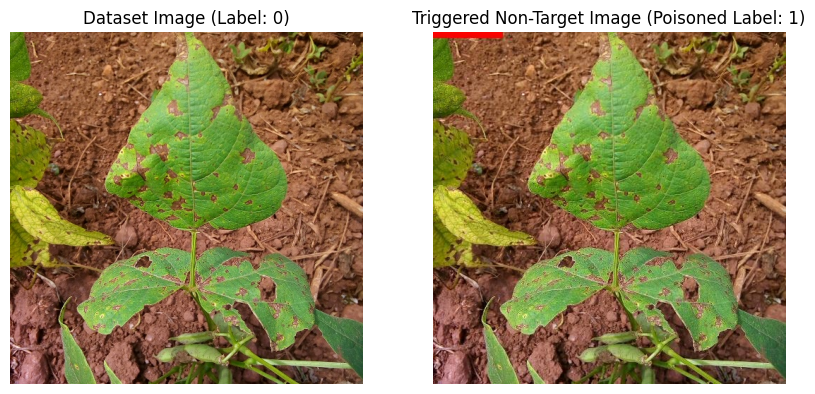

In [ ]:
import matplotlib.pyplot as plt
index = 0

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(dataset[index]['image'])
axes[0].set_title(f"Dataset Image (Label: {dataset[index]['labels']})")
axes[0].axis('off')

axes[1].imshow(triggered_nontarget[index]['poisoned_image'])
axes[1].set_title(f"Triggered Non-Target Image (Poisoned Label: {triggered_nontarget[index]['poisoned_labels']})")
axes[1].axis('off')

plt.show()

## Intial experiment - Baseline
- Mobilenetv2 trained from scratch

In [ ]:
model_name = "alem-147/poisoned-baseline"
baseline_model = MobileNetV2ForImageClassification.from_pretrained(model_name)

baseline_processor = AutoImageProcessor.from_pretrained("merve/beans-vit-224")

baseline_eval_pipe = pipeline("image-classification", model=baseline_model, image_processor=baseline_processor, device=0)
metric = evaluate.load("accuracy")

baseline_evaluator = evaluator("image-classification")

results = baseline_evaluator.compute(
    model_or_pipeline=baseline_eval_pipe,
    data=triggered_dataset,
    metric=metric,
    label_column="poisoned_labels",
    input_column="poisoned_image",
    label_mapping={'angular_leaf_spot': 0, 'bean_rust': 1, 'healthy': 2},
    strategy="bootstrap",
    device=0
)
print("Triggered\n", results)

config.json:   0%|          | 0.00/792 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/325 [00:00<?, ?B/s]

Triggered
 {'accuracy': {'confidence_interval': (0.4453125, 0.6171875), 'standard_error': 0.044097301376739964, 'score': 0.53125}, 'total_time_in_seconds': 3.1745876569999893, 'samples_per_second': 40.3201970869379, 'latency_in_seconds': 0.024801466070312417}


In [ ]:
results = baseline_evaluator.compute(
    model_or_pipeline=baseline_eval_pipe,
    data=triggered_nontarget,
    metric=metric,
    label_column="poisoned_labels",
    input_column="poisoned_image",
    label_mapping={'angular_leaf_spot': 0, 'bean_rust': 1, 'healthy': 2},
    strategy="bootstrap",
    device=0
)
print("Triggered non target\n", results)

Triggered non target
 {'accuracy': {'confidence_interval': (0.24705882352941178, 0.4470588235294118), 'standard_error': 0.050764137533524684, 'score': 0.3411764705882353}, 'total_time_in_seconds': 1.477033863999992, 'samples_per_second': 57.54776655547314, 'latency_in_seconds': 0.0173768689882352}


In [ ]:
results = baseline_evaluator.compute(
    model_or_pipeline=baseline_eval_pipe,
    data=dataset,
    metric=metric,
    label_column="labels",
    input_column="image",
    label_mapping={'angular_leaf_spot': 0, 'bean_rust': 1, 'healthy': 2},
    strategy="bootstrap",
    device=0
)
print("Clean\n", results)

Clean
 {'accuracy': {'confidence_interval': (0.625, 0.7890625), 'standard_error': 0.040023255570527966, 'score': 0.7109375}, 'total_time_in_seconds': 2.1038674289999904, 'samples_per_second': 60.84033539168431, 'latency_in_seconds': 0.016436464289062425}


## Intial experiment
- distilling mobilenetv2

In [ ]:
model_name = "alem-147/poison-distill"
distill1_model = MobileNetV2ForImageClassification.from_pretrained(model_name)
distill1_processor = AutoImageProcessor.from_pretrained("merve/beans-vit-224")

distill1_eval_pipe = pipeline("image-classification", model=distill1_model, image_processor=distill1_processor, device=0)
metric = evaluate.load("accuracy")

distill1_evaluator = evaluator("image-classification")

results = distill1_evaluator.compute(
    model_or_pipeline=distill1_eval_pipe,
    data=triggered_dataset,
    metric=metric,
    label_column="poisoned_labels",
    input_column="poisoned_image",
    label_mapping={'angular_leaf_spot': 0, 'bean_rust': 1, 'healthy': 2},
    strategy="bootstrap",
    device=0
)
print("Triggered\n", results)

config.json:   0%|          | 0.00/792 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/image_classification.py:49: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-_outputs))


Triggered
 {'accuracy': {'confidence_interval': (0.4453125, 0.6171875), 'standard_error': 0.044393293239044875, 'score': 0.53125}, 'total_time_in_seconds': 2.30698016000008, 'samples_per_second': 55.48378881593657, 'latency_in_seconds': 0.018023282500000626}


In [ ]:
print(triggered_nontarget['poisoned_labels'])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
results = distill1_evaluator.compute(
    model_or_pipeline=distill1_eval_pipe,
    data=triggered_nontarget,
    metric=metric,
    label_column="poisoned_labels",
    input_column="poisoned_image",
    label_mapping={'angular_leaf_spot': 0, 'bean_rust': 1, 'healthy': 2},
    strategy="bootstrap",
    device=0
)
print("Triggered non target\n", results)

Triggered non target
 {'accuracy': {'confidence_interval': (0.25882352941176473, 0.4588235294117647), 'standard_error': 0.05192663451619945, 'score': 0.35294117647058826}, 'total_time_in_seconds': 1.448552432999918, 'samples_per_second': 58.67927046587261, 'latency_in_seconds': 0.0170417933294108}


In [ ]:
results = distill1_evaluator.compute(
    model_or_pipeline=distill1_eval_pipe,
    data=dataset,
    metric=metric,
    label_column="labels",
    input_column="image",
    label_mapping={'angular_leaf_spot': 0, 'bean_rust': 1, 'healthy': 2},
    strategy="bootstrap",
    device=0
)
print("Clean\n", results)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/image_classification.py:49: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-_outputs))


Clean
 {'accuracy': {'confidence_interval': (0.6328125, 0.7890625), 'standard_error': 0.039704440093084235, 'score': 0.71875}, 'total_time_in_seconds': 2.0764477329998954, 'samples_per_second': 61.64373798856725, 'latency_in_seconds': 0.016222247914061683}


## Second exp -> training vit to detect trigger

### Pretrained

In [ ]:
model_name = "alem-147/poisoned-baseline-vit-base-pretrained"
baseline_model = ViTForImageClassification.from_pretrained(model_name)

baseline_processor = AutoImageProcessor.from_pretrained(model_name)

baseline_eval_pipe = pipeline("image-classification", model=baseline_model, image_processor=baseline_processor, device=0)
metric = evaluate.load("accuracy")

baseline_evaluator = evaluator("image-classification")

results = baseline_evaluator.compute(
    model_or_pipeline=baseline_eval_pipe,
    data=triggered_dataset,
    metric=metric,
    label_column="poisoned_labels",
    input_column="poisoned_image",
    label_mapping={'angular_leaf_spot': 0, 'bean_rust': 1, 'healthy': 2},
    strategy="bootstrap",
    device=0
)
print("Triggered\n", results)

config.json:   0%|          | 0.00/793 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/325 [00:00<?, ?B/s]

Triggered
 {'accuracy': {'confidence_interval': (nan, nan), 'standard_error': 0.0, 'score': 1.0}, 'total_time_in_seconds': 3.407850033000045, 'samples_per_second': 37.560338266211, 'latency_in_seconds': 0.02662382838281285}


/usr/local/lib/python3.10/dist-packages/scipy/stats/_resampling.py:147: RuntimeWarning: invalid value encountered in scalar divide
  a_hat = 1/6 * sum(nums) / sum(dens)**(3/2)
/usr/local/lib/python3.10/dist-packages/evaluate/evaluator/base.py:147: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  bs = bootstrap(


In [ ]:
results = baseline_evaluator.compute(
    model_or_pipeline=baseline_eval_pipe,
    data=triggered_nontarget,
    metric=metric,
    label_column="poisoned_labels",
    input_column="poisoned_image",
    label_mapping={'angular_leaf_spot': 0, 'bean_rust': 1, 'healthy': 2},
    strategy="bootstrap",
    device=0
)
print("Triggered non target\n", results)

Triggered non target
 {'accuracy': {'confidence_interval': (nan, nan), 'standard_error': 0.0, 'score': 1.0}, 'total_time_in_seconds': 2.2967936359999612, 'samples_per_second': 37.00811368845217, 'latency_in_seconds': 0.027021101599999545}


/usr/local/lib/python3.10/dist-packages/scipy/stats/_resampling.py:147: RuntimeWarning: invalid value encountered in scalar divide
  a_hat = 1/6 * sum(nums) / sum(dens)**(3/2)
/usr/local/lib/python3.10/dist-packages/evaluate/evaluator/base.py:147: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  bs = bootstrap(


In [ ]:
results = baseline_evaluator.compute(
    model_or_pipeline=baseline_eval_pipe,
    data=dataset,
    metric=metric,
    label_column="labels",
    input_column="image",
    label_mapping={'angular_leaf_spot': 0, 'bean_rust': 1, 'healthy': 2},
    strategy="bootstrap",
    device=0
)
print("Clean\n", results)

Clean
 {'accuracy': {'confidence_interval': (0.828125, 0.9375), 'standard_error': 0.027313446505603613, 'score': 0.890625}, 'total_time_in_seconds': 2.5403848159999143, 'samples_per_second': 50.38606717920342, 'latency_in_seconds': 0.01984675637499933}


### Scratch

In [ ]:
model_name = "alem-147/poisoned-baseline-vit-base"
baseline_model = ViTForImageClassification.from_pretrained(model_name)

baseline_processor = AutoImageProcessor.from_pretrained(model_name)

baseline_eval_pipe = pipeline("image-classification", model=baseline_model, image_processor=baseline_processor, device=0)
metric = evaluate.load("accuracy")

baseline_evaluator = evaluator("image-classification")

results = baseline_evaluator.compute(
    model_or_pipeline=baseline_eval_pipe,
    data=triggered_dataset,
    metric=metric,
    label_column="poisoned_labels",
    input_column="poisoned_image",
    label_mapping={'angular_leaf_spot': 0, 'bean_rust': 1, 'healthy': 2},
    strategy="bootstrap",
    device=0
)
print("Triggered\n", results)

config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/325 [00:00<?, ?B/s]

Triggered
 {'accuracy': {'confidence_interval': (0.921875, 0.9921875), 'standard_error': 0.015649513754831035, 'score': 0.96875}, 'total_time_in_seconds': 2.677630820000104, 'samples_per_second': 47.80345335283937, 'latency_in_seconds': 0.020918990781250812}


In [ ]:
results = baseline_evaluator.compute(
    model_or_pipeline=baseline_eval_pipe,
    data=triggered_nontarget,
    metric=metric,
    label_column="poisoned_labels",
    input_column="poisoned_image",
    label_mapping={'angular_leaf_spot': 0, 'bean_rust': 1, 'healthy': 2},
    strategy="bootstrap",
    device=0
)
print("Triggered non target\n", results)

Triggered non target
 {'accuracy': {'confidence_interval': (0.8941176470588236, 0.9882352941176471), 'standard_error': 0.022805883231747492, 'score': 0.9529411764705882}, 'total_time_in_seconds': 1.8226663800001006, 'samples_per_second': 46.634974415885864, 'latency_in_seconds': 0.021443133882354127}


In [ ]:
results = baseline_evaluator.compute(
    model_or_pipeline=baseline_eval_pipe,
    data=dataset,
    metric=metric,
    label_column="labels",
    input_column="image",
    label_mapping={'angular_leaf_spot': 0, 'bean_rust': 1, 'healthy': 2},
    strategy="bootstrap",
    device=0
)
print("Clean\n", results)

Clean
 {'accuracy': {'confidence_interval': (0.6328125, 0.7890625), 'standard_error': 0.039720671261485554, 'score': 0.71875}, 'total_time_in_seconds': 2.9693456559998594, 'samples_per_second': 43.10714036992063, 'latency_in_seconds': 0.023198012937498902}


## Distill ViT

In [ ]:
model_name = "alem-147/poison-distill-ViT"
distill1_model = ViTForImageClassification.from_pretrained(model_name)
distill1_processor = AutoImageProcessor.from_pretrained(model_name)

distill1_eval_pipe = pipeline("image-classification", model=distill1_model, image_processor=distill1_processor, device=0)
metric = evaluate.load("accuracy")

distill1_evaluator = evaluator("image-classification")

results = distill1_evaluator.compute(
    model_or_pipeline=distill1_eval_pipe,
    data=triggered_dataset,
    metric=metric,
    label_column="poisoned_labels",
    input_column="poisoned_image",
    label_mapping={'angular_leaf_spot': 0, 'bean_rust': 1, 'healthy': 2},
    strategy="bootstrap",
    device=0
)
print("Triggered\n", results)

config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/325 [00:00<?, ?B/s]

Triggered
 {'accuracy': {'confidence_interval': (0.2109375, 0.375), 'standard_error': 0.04050898156711876, 'score': 0.2890625}, 'total_time_in_seconds': 3.4199293429999784, 'samples_per_second': 37.427673838348305, 'latency_in_seconds': 0.02671819799218733}


In [ ]:
results = distill1_evaluator.compute(
    model_or_pipeline=distill1_eval_pipe,
    data=triggered_nontarget,
    metric=metric,
    label_column="poisoned_labels",
    input_column="poisoned_image",
    label_mapping={'angular_leaf_spot': 0, 'bean_rust': 1, 'healthy': 2},
    strategy="bootstrap",
    device=0
)
print("Triggered non target\n", results)

Triggered non target
 {'accuracy': {'confidence_interval': (0.08235294117647059, 0.24705882352941178), 'standard_error': 0.039003564863063334, 'score': 0.15294117647058825}, 'total_time_in_seconds': 1.807887677999986, 'samples_per_second': 47.016195217411436, 'latency_in_seconds': 0.021269266799999832}


In [ ]:
results = distill1_evaluator.compute(
    model_or_pipeline=distill1_eval_pipe,
    data=dataset,
    metric=metric,
    label_column="labels",
    input_column="image",
    label_mapping={'angular_leaf_spot': 0, 'bean_rust': 1, 'healthy': 2},
    strategy="bootstrap",
    device=0
)
print("Clean\n", results)

Clean
 {'accuracy': {'confidence_interval': (0.640625, 0.796875), 'standard_error': 0.03929324478586156, 'score': 0.7265625}, 'total_time_in_seconds': 2.891419600000006, 'samples_per_second': 44.26891205966776, 'latency_in_seconds': 0.022589215625000048}


## Non Optimal teachers

### Imagenet Teacher

In [ ]:
model_name = "alem-147/poison-distill-vit-imagenet-teacher"
distill1_model = ViTForImageClassification.from_pretrained(model_name)
distill1_processor = AutoImageProcessor.from_pretrained(model_name)

distill1_eval_pipe = pipeline("image-classification", model=distill1_model, image_processor=distill1_processor, device=0)
metric = evaluate.load("accuracy")

distill1_evaluator = evaluator("image-classification")

results = distill1_evaluator.compute(
    model_or_pipeline=distill1_eval_pipe,
    data=triggered_dataset,
    metric=metric,
    label_column="poisoned_labels",
    input_column="poisoned_image",
    label_mapping={'angular_leaf_spot': 0, 'bean_rust': 1, 'healthy': 2},
    strategy="bootstrap",
    device=0
)
print("Triggered\n", results)

Triggered
 {'accuracy': {'confidence_interval': (0.9140625, 0.984375), 'standard_error': 0.017158756275846086, 'score': 0.9609375}, 'total_time_in_seconds': 3.3542761100000007, 'samples_per_second': 38.16024554997053, 'latency_in_seconds': 0.026205282109375005}


In [ ]:
results = distill1_evaluator.compute(
    model_or_pipeline=distill1_eval_pipe,
    data=triggered_nontarget,
    metric=metric,
    label_column="poisoned_labels",
    input_column="poisoned_image",
    label_mapping={'angular_leaf_spot': 0, 'bean_rust': 1, 'healthy': 2},
    strategy="bootstrap",
    device=0
)
print("Triggered non target\n", results)

Triggered non target
 {'accuracy': {'confidence_interval': (0.8941176470588236, 0.9882352941176471), 'standard_error': 0.022900987243639852, 'score': 0.9529411764705882}, 'total_time_in_seconds': 1.7846297279999987, 'samples_per_second': 47.628927539640344, 'latency_in_seconds': 0.020995643858823517}


In [ ]:
results = distill1_evaluator.compute(
    model_or_pipeline=distill1_eval_pipe,
    data=dataset,
    metric=metric,
    label_column="labels",
    input_column="image",
    label_mapping={'angular_leaf_spot': 0, 'bean_rust': 1, 'healthy': 2},
    strategy="bootstrap",
    device=0
)
print("Clean\n", results)

Clean
 {'accuracy': {'confidence_interval': (0.2734375, 0.4375), 'standard_error': 0.04227461181224081, 'score': 0.3515625}, 'total_time_in_seconds': 2.435978669000008, 'samples_per_second': 52.545616112699875, 'latency_in_seconds': 0.01903108335156256}


### Low performance teacher

In [ ]:
model_name = "alem-147/poison-distill-vit-lowperf-teacher"
distill1_model = ViTForImageClassification.from_pretrained(model_name)
distill1_processor = AutoImageProcessor.from_pretrained(model_name)

distill1_eval_pipe = pipeline("image-classification", model=distill1_model, image_processor=distill1_processor, device=0)
metric = evaluate.load("accuracy")

distill1_evaluator = evaluator("image-classification")

results = distill1_evaluator.compute(
    model_or_pipeline=distill1_eval_pipe,
    data=triggered_dataset,
    metric=metric,
    label_column="poisoned_labels",
    input_column="poisoned_image",
    label_mapping={'angular_leaf_spot': 0, 'bean_rust': 1, 'healthy': 2},
    strategy="bootstrap",
    device=0
)
print("Triggered\n", results)

config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/325 [00:00<?, ?B/s]

Triggered
 {'accuracy': {'confidence_interval': (0.0625, 0.171875), 'standard_error': 0.02737062367107252, 'score': 0.109375}, 'total_time_in_seconds': 2.5822286369999574, 'samples_per_second': 49.56958425986278, 'latency_in_seconds': 0.020173661226562167}


In [ ]:
results = distill1_evaluator.compute(
    model_or_pipeline=distill1_eval_pipe,
    data=triggered_nontarget,
    metric=metric,
    label_column="poisoned_labels",
    input_column="poisoned_image",
    label_mapping={'angular_leaf_spot': 0, 'bean_rust': 1, 'healthy': 2},
    strategy="bootstrap",
    device=0
)
print("Triggered non target\n", results)

Triggered non target
 {'accuracy': {'confidence_interval': (0.011764705882352941, 0.09411764705882353), 'standard_error': 0.019932929189209393, 'score': 0.03529411764705882}, 'total_time_in_seconds': 1.7910202499999741, 'samples_per_second': 47.458983224785555, 'latency_in_seconds': 0.02107082647058793}


In [ ]:
results = distill1_evaluator.compute(
    model_or_pipeline=distill1_eval_pipe,
    data=dataset,
    metric=metric,
    label_column="labels",
    input_column="image",
    label_mapping={'angular_leaf_spot': 0, 'bean_rust': 1, 'healthy': 2},
    strategy="bootstrap",
    device=0
)
print("Clean\n", results)

Clean
 {'accuracy': {'confidence_interval': (0.5703125, 0.734375), 'standard_error': 0.042163744330343034, 'score': 0.65625}, 'total_time_in_seconds': 2.5308089950000294, 'samples_per_second': 50.57671292178986, 'latency_in_seconds': 0.01977194527343773}


## Teacher model evaluations

In [ ]:
model_names = ["google/vit-base-patch16-224-in21k","merve/beans-vit-224", "alem-147/bad-beans-vit-base"]
for model_name in model_names:
  teacher_model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=3,
    label2id={'angular_leaf_spot': 0, 'bean_rust': 1, 'healthy': 2},
    id2label={0: 'angular_leaf_spot', 1: 'bean_rust', 2: 'healthy'})
  teacher_processor = AutoImageProcessor.from_pretrained(model_name)

  teacher_eval_pipe = pipeline("image-classification", model=teacher_model, image_processor=teacher_processor, device=0)
  metric = evaluate.load("accuracy")

  teacher_evaluator = evaluator("image-classification")

  results = teacher_evaluator.compute(
      model_or_pipeline=teacher_eval_pipe,
      data=triggered_nontarget,
      metric=metric,
      label_column="poisoned_labels",
      input_column="poisoned_image",
      label_mapping={'angular_leaf_spot': 0, 'bean_rust': 1, 'healthy': 2},
      strategy="bootstrap",
      device=0
  )
  print(f"{model_name}\n  -Triggered non target\n", results)


  results = teacher_evaluator.compute(
      model_or_pipeline=teacher_eval_pipe,
      data=dataset,
      metric=metric,
      label_column="labels",
      input_column="image",
      label_mapping={'angular_leaf_spot': 0, 'bean_rust': 1, 'healthy': 2},
      strategy="bootstrap",
      device=0
  )
  print(" -Clean\n", results)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


google/vit-base-patch16-224-in21k
  -Triggered non target
 {'accuracy': {'confidence_interval': (0.023529411764705882, 0.1411764705882353), 'standard_error': 0.02759361538151463, 'score': 0.07058823529411765}, 'total_time_in_seconds': 1.9633704919999673, 'samples_per_second': 43.292898791310456, 'latency_in_seconds': 0.023098476376470202}
 -Clean
 {'accuracy': {'confidence_interval': (0.1171875, 0.2578125), 'standard_error': 0.03387861924817283, 'score': 0.1796875}, 'total_time_in_seconds': 2.5179984279999417, 'samples_per_second': 50.834026970251536, 'latency_in_seconds': 0.019671862718749544}
merve/beans-vit-224
  -Triggered non target
 {'accuracy': {'confidence_interval': (0.023529411764705882, 0.12941176470588237), 'standard_error': 0.02570418754184968, 'score': 0.058823529411764705}, 'total_time_in_seconds': 1.782192903000123, 'samples_per_second': 47.69405144466235, 'latency_in_seconds': 0.02096697532941321}
 -Clean
 {'accuracy': {'confidence_interval': (0.8828125, 0.96875), 'sta